In [1]:
!pip install -U transformers>=4.48.0

In [2]:
import ast
import copy
import gc
import itertools
import joblib
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy as sp
import string
import sys
import time
import warnings
import wandb


from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# ======= OPTIONS =========
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is: {device}")
warnings.filterwarnings("ignore")
!mkdir output

Current device is: cuda


### <b><span style='color:#F1A424'>Tokenizers and transformers</span></b>

In [3]:
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.21.0
transformers.__version__: 4.51.3


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

Central repository for this notebook's hyperparameters.

In [4]:
class config:
    APEX = True # Automatic Precision Enabled
    BATCH_SCHEDULER = True
    BATCH_SIZE_TRAIN = 64
    BATCH_SIZE_VALID = 64
    BETAS = (0.9, 0.999)
    DEBUG = False
    DECODER_LR = 6e-5
    ENCODER_LR = 4e-5
    EPOCHS = 6
    EPS = 1e-6
    FOLDS = 4
    GRADIENT_ACCUMULATION_STEPS = 1
    GRADIENT_CHECKPOINTING = True
    MAX_GRAD_NORM=5000
    MAX_LEN = 384
    MIN_LR = 1e-6
    MODEL = "microsoft/deberta-v3-large"
    NUM_CYCLES = 0.5
    NUM_CLASSES = 12
    NUM_WARMUP_STEPS = 0
    NUM_WORKERS = 0 #multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SCHEDULER = 'linear' # ['linear', 'cosine']
    SEED = 29
    TRAIN = True
    TRAIN_FOLDS = [0, 1, 2, 3]
    WEIGHT_DECAY = 0.01

    
class paths:
    OUTPUT_DIR = "/kaggle/working/output"
    TRAIN_ESSAYS = "/kaggle/input/workshop-task-acl/relations.csv"    

if config.DEBUG:
    config.EPOCHS = 10
    config.TRAIN_FOLDS = [0]

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions used throughout the notebook.

In [5]:
def get_config_dict(config):
    """
    Return the config, which is originally a class, as a Python dictionary.
    """
    config_dict = dict((key, value) for key, value in config.__dict__.items() 
    if not callable(value) and not key.startswith('__'))
    return config_dict


def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler
    

def get_score(y_trues, y_preds):
    # score = roc_auc_score(y_trues, y_preds)
    score = f1_score(y_trues, y_preds, average='macro')
    return score


def seed_everything(seed=20):
    """Seed everything to ensure reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

def sep():
    print("-"*100)
    
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  

from scipy.special import softmax
    
LOGGER = get_logger()
seed_everything(seed=config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load data.

In [7]:
with open("/kaggle/input/workshop-task-acl/SOMD2025-PhaseI/train_texts.txt", "r", encoding="utf-8") as file:
    text = file.read()

text_list = text.split('\n')

with open("/kaggle/input/workshop-task-acl/SOMD2025-PhaseI/train_entities.txt", "r", encoding="utf-8") as file:
    text = file.read()

labels_list = text.split('\n')
df = pd.DataFrame()
df['train_text'] = text_list
df['train_labels'] = labels_list
df['train_text_list'] = df['train_text'].str.split(' ')
df['train_labels_list'] = df['train_labels'].str.split(' ')
df['document'] = np.arange(len(df))
df['train_labels_list'] = df['train_labels_list'].apply(lambda tags: [tag.replace('I-', 'B-') for tag in tags])
df['unique_labels'] = df['train_labels_list'].apply(lambda x: ' '.join(list(set(x))))

In [8]:
with open("/kaggle/input/workshop-task-acl/SOMD2025-PhaseI/train_relations.txt", "r", encoding="utf-8") as file:
    text = file.read()

text_list = text.split('\n')


# Process the data safely
records = []
for i, row in enumerate(text_list):
    relations = row.split('; ')
    
    if len(relations[0])!=0:
        for relation in relations:
            parts = relation.split('\t')
            rel_type, ent1, ent2 = parts
            records.append({'Relation': rel_type, 'Entity_1': int(ent1), 'Entity_2': int(ent2), 'document': i})
    else:
        records.append({'Relation': np.nan, 'Entity_1': np.nan, 'Entity_2': np.nan, 'document': i})
            

# # Convert to DataFrame
relations = pd.DataFrame(records)
relations['Relation'] = relations['Relation'].fillna('no_relation')
relations['Entity_1'] = relations['Entity_1'].fillna(0).astype(int)
relations['Entity_2'] = relations['Entity_2'].fillna(0).astype(int)

df2 = df[['train_text_list', 'train_labels_list', 'document']]
relations = relations.join(df2.set_index('document'), on = 'document')

relations['entity_type_1'] = relations.apply(lambda row: row['train_labels_list'][row['Entity_1']], axis = 1)
relations['entity_type_2'] = relations.apply(lambda row: row['train_labels_list'][row['Entity_2']], axis = 1)

relations_null = relations[relations['Relation']=='no_relation'].reset_index(drop = True)
relations_nn = relations[relations['Relation']!='no_relation'].reset_index(drop = True)

relations_nn['entity_1_indexs'] = relations_nn.apply(
    lambda row: [row['Entity_1']] + [
        i for i in range(row['Entity_1'] + 1, len(row['train_labels_list'])) 
        if row['train_labels_list'][i].startswith(f"I-{row['entity_type_1'].split('-')[1]}")
    ], axis=1
)

relations_nn['entity_2_indexs'] = relations_nn.apply(
    lambda row: [row['Entity_2']] + [
        i for i in range(row['Entity_2'] + 1, len(row['train_labels_list'])) 
        if row['train_labels_list'][i].startswith(f"I-{row['entity_type_2'].split('-')[1]}")
    ], axis=1
)

relations_nn['entity_1_text'] = relations_nn.apply(
    lambda row: " ".join([row['train_text_list'][idxs] for idxs in row['entity_1_indexs']]), axis=1)

relations_nn['entity_2_text'] = relations_nn.apply(
    lambda row: " ".join([row['train_text_list'][idxs] for idxs in row['entity_2_indexs']]), axis=1)

relations = pd.concat([relations_nn, relations_null]).reset_index(drop = True)

relations['entity_1_indexs'] = relations['entity_1_indexs'].fillna('null')
relations['entity_2_indexs'] = relations['entity_2_indexs'].fillna('null')
relations['entity_1_text'] = relations['entity_1_text'].fillna('O')
relations['entity_2_text'] = relations['entity_2_text'].fillna('O')
relations['entity_type_1'] = relations['entity_type_1'].fillna('O')
relations['entity_type_2'] = relations['entity_type_2'].fillna('O')

relations = relations[['Relation', 'entity_type_1', 'entity_type_2', 'entity_1_text', 'entity_2_text', 'document']]
relations = relations.sort_values('document').reset_index(drop = True)
relations

,Relation,entity_type_1,entity_type_2,entity_1_text,entity_2_text,document
0,Developer_of,B-Developer,B-Application,Software,Remote,0
1,URL_of,B-URL,B-Application,http://softwaresecure.com,Remote,0
2,URL_of,B-URL,B-Application,http://proctoru.com,ProctorU,0
3,Version_of,B-Version,B-Application,3.1,ArcView,1
4,Citation_of,B-Citation,B-PlugIn,[39],Patch,1
...,...,...,...,...,...,...
2675,Version_of,B-Version,B-Application,2010,Excel,1145
2676,no_relation,O,O,O,O,1146
2677,URL_of,B-URL,B-Application,github.com,Ensembler,1147
2678,URL_of,B-URL,B-Application,https://github.com/guigolab/ggsashimi,ggsashimi,1148


In [9]:
relations['entity_text_type_1'] = relations['entity_type_1'] + ' [SEP] ' + relations['entity_1_text']
relations['entity_text_type_2'] = relations['entity_type_2'] + ' [SEP] ' + relations['entity_2_text']

In [10]:
import pandas as pd
from itertools import product

def create_aug_data(df):
    df = df[['Relation', 'entity_text_type_1', 'entity_text_type_2', 'document']]
    entity_text_type_1_list = df["entity_text_type_1"].unique().tolist()
    entity_text_type_2_list = df["entity_text_type_2"].unique().tolist()
    
    # Get all unique document IDs
    documents = df["document"].unique()
    
    # Track existing rows to avoid duplicates
    existing = set(zip(
        df["entity_text_type_1"],
        df["entity_text_type_2"],
        df["document"]
    ))
    
    # Generate all possible combinations for each document
    new_rows = []
    for doc in documents:
        for et1, et2 in product(entity_text_type_1_list, entity_text_type_2_list):
            key = (et1, et2, doc)
            if key not in existing:
                new_rows.append(("no_relation", et1, et2, doc))
    
    # Combine original with new rows
    df_augmented = pd.concat([
        df,
        pd.DataFrame(new_rows, columns=df.columns)
    ], ignore_index=True)
    
    # Optional: sort for readability
    df_augmented = df_augmented.sort_values(by=["entity_text_type_1", "entity_text_type_2", "Relation", 'document']).reset_index(drop=True)

    return df_augmented

rtt = pd.DataFrame()
for i in relations['document'].unique():
    rt = create_aug_data(relations[relations['document']==i])
    rtt = pd.concat([rtt, rt]).reset_index(drop=True)

In [11]:
rtt[rtt['document']==0]

,Relation,entity_text_type_1,entity_text_type_2,document
0,no_relation,B-Developer [SEP] Software,B-Application [SEP] ProctorU,0
1,Developer_of,B-Developer [SEP] Software,B-Application [SEP] Remote,0
2,URL_of,B-URL [SEP] http://proctoru.com,B-Application [SEP] ProctorU,0
3,no_relation,B-URL [SEP] http://proctoru.com,B-Application [SEP] Remote,0
4,no_relation,B-URL [SEP] http://softwaresecure.com,B-Application [SEP] ProctorU,0
5,URL_of,B-URL [SEP] http://softwaresecure.com,B-Application [SEP] Remote,0


In [12]:
rtt = rtt.join(df.set_index('document'), on = 'document')

In [13]:
rtt['relation_text'] = rtt['train_text'] + ' [SEP] ' + rtt['entity_text_type_1'] + ' [SEP] ' + rtt['entity_text_type_2']

In [14]:
train_df = rtt

# <b><span style='color:#F1A424'>|</span> Validation</b><a class='anchor' id='validation'></a> [↑](#top) 

***

We will use a `StratifiedKFold` partition, stratifying by `generated`.

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4)
X = train_df['relation_text']

labels_dict = {}
for i, key in enumerate(train_df['Relation'].unique()):
    labels_dict[key] = i

train_df['labels'] = train_df['Relation'].apply(lambda x: labels_dict[x])

y = train_df['labels'].values

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    train_df.loc[valid_index, "fold"] = i
    
print(train_df.groupby("fold")["labels"].value_counts())
train_df.head()

fold  labels
0.0   0         402
      5         226
      1         156
      3          97
      2          54
      4          35
      8          17
      7          14
      9          14
      6          11
      10         10
      11          4
1.0   0         402
      5         226
      1         156
      3          97
      2          54
      4          35
      8          18
      9          14
      7          13
      6          11
      10         10
      11          4
2.0   0         402
      5         226
      1         155
      3          97
      2          55
      4          35
      8          17
      9          15
      7          13
      6          11
      10         10
      11          3
3.0   0         401
      5         226
      1         156
      3          96
      2          55
      4          36
      8          17
      9          15
      7          13
      6          11
      10         10
      11          3
Name: count, dtype: int64


,Relation,entity_text_type_1,entity_text_type_2,document,train_text,train_labels,train_text_list,train_labels_list,unique_labels,relation_text,labels,fold
0,no_relation,B-Developer [SEP] Software,B-Application [SEP] ProctorU,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",O B-Developer B-Application B-URL,"Depending on the course , instructor , and exa...",0,0.0
1,Developer_of,B-Developer [SEP] Software,B-Application [SEP] Remote,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",O B-Developer B-Application B-URL,"Depending on the course , instructor , and exa...",1,0.0
2,URL_of,B-URL [SEP] http://proctoru.com,B-Application [SEP] ProctorU,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",O B-Developer B-Application B-URL,"Depending on the course , instructor , and exa...",2,0.0
3,no_relation,B-URL [SEP] http://proctoru.com,B-Application [SEP] Remote,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",O B-Developer B-Application B-URL,"Depending on the course , instructor , and exa...",0,0.0
4,no_relation,B-URL [SEP] http://softwaresecure.com,B-Application [SEP] ProctorU,0,"Depending on the course , instructor , and exa...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[Depending, on, the, course, ,, instructor, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",O B-Developer B-Application B-URL,"Depending on the course , instructor , and exa...",0,0.0


# <b><span style='color:#F1A424'>|</span> Tokenizer</b><a class='anchor' id='tokenizer'></a> [↑](#top) 

***

In [16]:
labels_dict

{'no_relation': 0,
 'Developer_of': 1,
 'URL_of': 2,
 'Citation_of': 3,
 'PlugIn_of': 4,
 'Version_of': 5,
 'Extension_of': 6,
 'Specification_of': 7,
 'Release_of': 8,
 'Abbreviation_of': 9,
 'License_of': 10,
 'AlternativeName_of': 11}

In [17]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)
tokenizer.save_pretrained(paths.OUTPUT_DIR + '/tokenizer/')
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-large', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

    
We need to get the `max_len` from our `tokenizer`. We create a `tqdm` iterator and for each text we extract the tokenized length. Then we get the maximum value and we add 3 for the special tokens `CLS`, `SEP`, `SEP`.

- [Hugging Face Padding and Truncation](https://huggingface.co/docs/transformers/pad_truncation): check truncation to `max_length` or `True` (batch max length).

  0%|          | 0/4158 [00:00<?, ?it/s]

max_len: 384


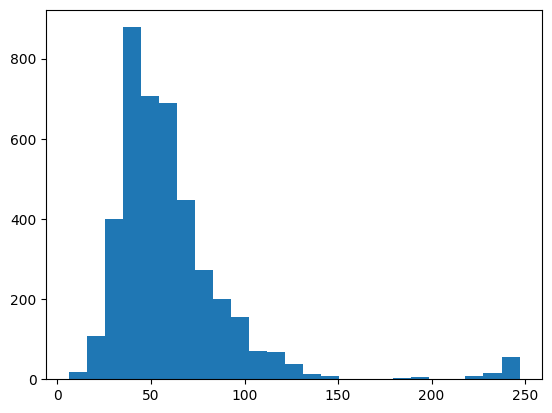

In [18]:
lengths = []
tqdm_loader = tqdm(train_df['relation_text'].fillna("").values, total=len(train_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
    
# config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {config.MAX_LEN}")
_ = plt.hist(lengths, bins=25)

In [19]:
def prepare_input(cfg, text, tokenizer):
    """
    This function tokenizes the input text with the configured padding and truncation. Then,
    returns the input dictionary, which contains the following keys: "input_ids",
    "token_type_ids" and "attention_mask". Each value is a torch.tensor.
    :param cfg: configuration class with a TOKENIZER attribute.
    :param text: a numpy array where each value is a text as string.
    :return inputs: python dictionary where values are torch tensors.
    """
    inputs = tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.MAX_LEN,
        padding='max_length', # TODO: check padding to max sequence in batch
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # TODO: check dtypes
    return inputs


def collate(inputs):
    """
    It truncates the inputs to the maximum sequence length in the batch. 
    """
    mask_len = int(inputs["attention_mask"].sum(axis=1).max()) # Get batch's max sequence length
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs


class CustomDataset(Dataset):
    def __init__(self, cfg, df, tokenizer):
        self.cfg = cfg
        self.texts = df['relation_text'].values
        self.labels = df['labels'].values
        self.tokenizer = tokenizer
        self.text_ids = df['document'].values
        self.num_classes = 12  # Number of unique classes

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        output = {}
        output["inputs"] = prepare_input(self.cfg, self.texts[item], self.tokenizer)        
        output["labels"] = torch.tensor(self.labels[item], dtype=torch.long)
        output["document"] = self.text_ids[item]
        return output


One sample from the dataset should look as following:
```python
{
	'inputs': {
		'input_ids': tensor([1, 279, 883, ..., 0, 0]),
		'token_type_ids': tensor([0, 0, 0, ..., 0, 0]),
		'attention_mask': tensor([1, 1, 1, ..., 0, 0])
	},
	'label': tensor([0.0]),
	'document': '000e8c3c7ddb'
}
```
You can check it by running the cell below.

In [20]:
if True:
    # ======== SPLIT ==========
    fold = 0
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['labels'].values
    print(valid_folds['labels'].nunique())

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)

    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # === Let's check one sample ===
    sample = train_dataset[0]
    print(f"Encoding keys: {sample.keys()} \n") 
    print(sample)

12
Encoding keys: dict_keys(['inputs', 'labels', 'document']) 

{'inputs': {'input_ids': tensor([    1,   279,  2288,   269,  4928,   494, 30298,  1849,  2384, 10042,
          263,   499,   288,  1871,   294,   320,   320, 27905,   260, 27446,
          260,   549,   320,  5214,   320, 60522, 14727, 32624,   323,     2,
          736,   271, 75493,     2, 30298,     2,   736,   271, 46326,  9360,
        32553,     2,  2288,     2,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

In [21]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings


class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        # Load config by inferencing it from the model name.
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.MODEL, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)

        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.MODEL, config=self.config)
        else:
            self.model = AutoModel(self.config)

        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()

        # Add MeanPooling and Linear head at the end to transform the Model into a RegressionModel
        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, 12)
        self._init_weights(self.fc)

    def _init_weights(self, module):
        """
        This method initializes weights for different types of layers. The type of layers
        supported are nn.Linear, nn.Embedding and nn.LayerNorm.
        """
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        """
        This method makes a forward pass through the model, get the last hidden state (embedding)
        and pass it through the MeanPooling layer.
        """
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        """
        This method makes a forward pass through the model, the MeanPooling layer and finally
        then through the Linear layer to get a regression value.
        """
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***
    
- [torch.cuda.amp.GradScaler](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler): This class helps writing compute efficient training loops, so we dont get OOM errors. Also, one common error in any large deep learning model is the problem of underflowing gradients (i.e. your gradients are too small to take into account). `float16` tensors often don't take into account extremely small variations. To prevent this we can scale our gradients by some factor so that they aren't flushed to zero. Not to be confused with vanishing gradients, this gradients still might contribute to the learning process however are skipped because of computational limits.
- [torch.autocast](https://pytorch.org/docs/stable/amp.html#torch.autocast)

In [22]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() # set model in train mode
    scaler = torch.cuda.amp.GradScaler(enabled=config.APEX) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
    losses = AverageMeter() # initiate AverageMeter to track the loss.
    start = end = time.time() # track the execution time.
    global_step = 0

    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items(): # send each tensor value to `device`
                inputs[k] = v.to(device)
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.cuda.amp.autocast(enabled=config.APEX):
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            scaler.scale(loss).backward() # backward propagation pass
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer) # update optimizer parameters
                scaler.update()
                optimizer.zero_grad() # zero out the gradients
                global_step += 1
                if config.BATCH_SCHEDULER:
                    scheduler.step() # update learning rate
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader),
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_lr()[0]))

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval() # set model in evaluation mode
    losses = AverageMeter() # initiate AverageMeter for tracking the loss.
    prediction_dict = {}
    preds = []
    start = end = time.time() # track the execution time.
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            document_ids = batch.pop("document")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items():
                inputs[k] = v.to(device) # send inputs to device
            labels = labels.to(device)
            batch_size = labels.size(0)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            preds.append(y_preds.to('cpu').numpy()) # save predictions
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              loss=losses,
                              remain=timeSince(start, float(step+1)/len(valid_loader))))

    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    prediction_dict[""] = document_ids
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [23]:
def train_loop(folds, fold):

    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    # train_folds = pd.concat([train_folds, valid_folds]).reset_index(drop=True)
    valid_labels = valid_folds["labels"].values

    test_folds = pd.read_csv('/kaggle/input/workshop-task-acl/relations_test.csv')
    test_folds['labels'] = 0
    test_folds = test_folds.rename(columns={"entity_doc": "document", "relation_text_1": "relation_text"})
    # test_folds = test_folds[['entity_doc', 'relation_text_1', 'labels']]
    # test_folds.columns = ['document', 'relation_text', 'labels']

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)
    test_dataset = CustomDataset(config, test_folds, tokenizer)

    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)
    test_loader = DataLoader(test_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # ======== MODEL ==========
    model = CustomModel(config, config_path=None, pretrained=True)
    torch.save(model.config, paths.OUTPUT_DIR + '/config.pth')
    model.to(device)

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=config.ENCODER_LR,
                                                decoder_lr=config.DECODER_LR,
                                                weight_decay=config.WEIGHT_DECAY)
    optimizer = AdamW(
        optimizer_parameters,
        lr=config.ENCODER_LR,
        eps=config.EPS,
        betas=config.BETAS
    )


    num_train_steps = int(len(train_folds) / config.BATCH_SIZE_TRAIN * config.EPOCHS)
    scheduler = get_scheduler(config, optimizer, num_train_steps)

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    best_val_loss = np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):

        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)
        predictions_proba = softmax(torch.tensor(prediction_dict["predictions"]))

        _, test_dict = valid_epoch(test_loader, model, criterion, device)
        test_pred = test_dict["predictions"]
        _, test_pred = torch.max(softmax(torch.tensor(test_pred)), dim=1)
        test_preds_proba = softmax(torch.tensor(test_dict["predictions"]))

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best val score: {score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth")

    predictions = torch.load(paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth",
                             map_location=torch.device('cpu'))['predictions']
    
    valid_folds["preds"] = predictions
    test_folds["preds"] = test_pred
    
    torch.cuda.empty_cache()
    gc.collect()

    return valid_folds, test_folds, predictions_proba, test_preds_proba

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [24]:
if __name__ == '__main__':
    def get_result(oof_df):
        labels = oof_df["labels"].values
        preds = oof_df["preds"].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if config.TRAIN:
        oof_df = pd.DataFrame()
        for fold in range(config.FOLDS):
            if fold == 2:
                _oof_df, test_folds, predictions_proba, test_preds_proba = train_loop(train_df, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== Fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)
        test_folds.to_csv(paths.OUTPUT_DIR + '/test_fold.csv', index=False)

========== Fold: 2 training ==========
2025-04-16 19:12:13.958662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744830734.136331      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744830734.189180      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [1][0/48] Elapsed 0m 8s (remain 6m 28s) Loss: 2.5456 Grad: inf  LR: 0.00003986  
Epoch: [1][20/48] Elapsed 2m 17s (remain 2m 56s) Loss: 1.6032 Grad: 45204.0703  LR: 0.00003712  
Epoch: [1][40/48] Elapsed 4m 41s (remain 0m 48s) Loss: 1.1506 Grad: 51792.8906  LR: 0.00003438  
Epoch: [1][47/48] Elapsed 5m 28s (remain 0m 0s) Loss: 1.0644 Grad: 75337.9688  LR: 0.00003342  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 1s (remain 0m 29s) Loss: 0.9767 
EVAL: [16/17] Elapsed 0m 15s (remain 0m 0s) Loss: 0.4803 


Validation:   0%|          | 0/66 [00:00<?, ?valid_batch/s]

EVAL: [0/66] Elapsed 0m 0s (remain 0m 57s) Loss: 1.4627 
EVAL: [20/66] Elapsed 0m 20s (remain 0m 43s) Loss: 1.1041 
EVAL: [40/66] Elapsed 0m 44s (remain 0m 27s) Loss: 1.1343 
EVAL: [60/66] Elapsed 1m 6s (remain 0m 5s) Loss: 1.0592 


Epoch 1 - avg_train_loss: 1.0644  avg_val_loss: 0.4803  time: 413s
Epoch 1 - Score: 0.5699
Epoch 1 - Save Best val score: 0.5699 Model


EVAL: [65/66] Elapsed 1m 9s (remain 0m 0s) Loss: 1.0726 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [2][0/48] Elapsed 0m 7s (remain 5m 54s) Loss: 0.4789 Grad: 497553.8125  LR: 0.00003329  
Epoch: [2][20/48] Elapsed 2m 32s (remain 3m 15s) Loss: 0.3738 Grad: 187466.3125  LR: 0.00003055  
Epoch: [2][40/48] Elapsed 4m 47s (remain 0m 49s) Loss: 0.2936 Grad: 128026.0625  LR: 0.00002781  
Epoch: [2][47/48] Elapsed 5m 32s (remain 0m 0s) Loss: 0.2815 Grad: 252476.0938  LR: 0.00002685  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6756 
EVAL: [16/17] Elapsed 0m 14s (remain 0m 0s) Loss: 0.1775 


Validation:   0%|          | 0/66 [00:00<?, ?valid_batch/s]

EVAL: [0/66] Elapsed 0m 0s (remain 0m 57s) Loss: 1.8971 
EVAL: [20/66] Elapsed 0m 20s (remain 0m 43s) Loss: 1.2841 
EVAL: [40/66] Elapsed 0m 44s (remain 0m 27s) Loss: 1.1902 
EVAL: [60/66] Elapsed 1m 6s (remain 0m 5s) Loss: 1.1274 


Epoch 2 - avg_train_loss: 0.2815  avg_val_loss: 0.1775  time: 417s
Epoch 2 - Score: 0.8394
Epoch 2 - Save Best val score: 0.8394 Model


EVAL: [65/66] Elapsed 1m 9s (remain 0m 0s) Loss: 1.1415 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [3][0/48] Elapsed 0m 7s (remain 5m 54s) Loss: 0.1215 Grad: 165488.7344  LR: 0.00002671  
Epoch: [3][20/48] Elapsed 2m 16s (remain 2m 54s) Loss: 0.0975 Grad: 189513.3438  LR: 0.00002397  
Epoch: [3][40/48] Elapsed 4m 28s (remain 0m 45s) Loss: 0.1006 Grad: 400902.2812  LR: 0.00002123  
Epoch: [3][47/48] Elapsed 5m 16s (remain 0m 0s) Loss: 0.1016 Grad: 480348.8438  LR: 0.00002027  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 1s (remain 0m 29s) Loss: 0.6102 
EVAL: [16/17] Elapsed 0m 14s (remain 0m 0s) Loss: 0.1347 


Validation:   0%|          | 0/66 [00:00<?, ?valid_batch/s]

EVAL: [0/66] Elapsed 0m 0s (remain 0m 58s) Loss: 2.3416 
EVAL: [20/66] Elapsed 0m 20s (remain 0m 43s) Loss: 1.5185 
EVAL: [40/66] Elapsed 0m 44s (remain 0m 27s) Loss: 1.4343 
EVAL: [60/66] Elapsed 1m 6s (remain 0m 5s) Loss: 1.3464 


Epoch 3 - avg_train_loss: 0.1016  avg_val_loss: 0.1347  time: 401s
Epoch 3 - Score: 0.9302
Epoch 3 - Save Best val score: 0.9302 Model


EVAL: [65/66] Elapsed 1m 9s (remain 0m 0s) Loss: 1.3627 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [4][0/48] Elapsed 0m 7s (remain 5m 55s) Loss: 0.0319 Grad: 104097.0000  LR: 0.00002014  
Epoch: [4][20/48] Elapsed 2m 23s (remain 3m 4s) Loss: 0.0448 Grad: 88453.7188  LR: 0.00001740  
Epoch: [4][40/48] Elapsed 4m 22s (remain 0m 44s) Loss: 0.0520 Grad: 522246.8438  LR: 0.00001466  
Epoch: [4][47/48] Elapsed 5m 14s (remain 0m 0s) Loss: 0.0490 Grad: 23830.3828  LR: 0.00001370  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 1s (remain 0m 29s) Loss: 0.4338 
EVAL: [16/17] Elapsed 0m 14s (remain 0m 0s) Loss: 0.1300 


Validation:   0%|          | 0/66 [00:00<?, ?valid_batch/s]

EVAL: [0/66] Elapsed 0m 0s (remain 0m 58s) Loss: 3.0565 
EVAL: [20/66] Elapsed 0m 20s (remain 0m 43s) Loss: 1.9921 
EVAL: [40/66] Elapsed 0m 44s (remain 0m 27s) Loss: 1.8673 
EVAL: [60/66] Elapsed 1m 6s (remain 0m 5s) Loss: 1.7563 


Epoch 4 - avg_train_loss: 0.0490  avg_val_loss: 0.1300  time: 399s
Epoch 4 - Score: 0.9368
Epoch 4 - Save Best val score: 0.9368 Model


EVAL: [65/66] Elapsed 1m 9s (remain 0m 0s) Loss: 1.7727 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [5][0/48] Elapsed 0m 7s (remain 5m 55s) Loss: 0.0078 Grad: 13468.7178  LR: 0.00001356  
Epoch: [5][20/48] Elapsed 2m 19s (remain 2m 58s) Loss: 0.0314 Grad: 6722.2505  LR: 0.00001082  
Epoch: [5][40/48] Elapsed 4m 45s (remain 0m 48s) Loss: 0.0238 Grad: 8491.3926  LR: 0.00000808  
Epoch: [5][47/48] Elapsed 5m 29s (remain 0m 0s) Loss: 0.0240 Grad: 7983.7935  LR: 0.00000712  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 1s (remain 0m 29s) Loss: 0.4929 
EVAL: [16/17] Elapsed 0m 14s (remain 0m 0s) Loss: 0.1574 


Validation:   0%|          | 0/66 [00:00<?, ?valid_batch/s]

EVAL: [0/66] Elapsed 0m 0s (remain 0m 57s) Loss: 3.8805 
EVAL: [20/66] Elapsed 0m 20s (remain 0m 43s) Loss: 2.6150 
EVAL: [40/66] Elapsed 0m 44s (remain 0m 27s) Loss: 2.3995 
EVAL: [60/66] Elapsed 1m 6s (remain 0m 5s) Loss: 2.2456 


Epoch 5 - avg_train_loss: 0.0240  avg_val_loss: 0.1574  time: 414s
Epoch 5 - Score: 0.9617
Epoch 5 - Save Best val score: 0.9617 Model


EVAL: [65/66] Elapsed 1m 9s (remain 0m 0s) Loss: 2.2620 


Train:   0%|          | 0/48 [00:00<?, ?train_batch/s]

Epoch: [6][0/48] Elapsed 0m 7s (remain 5m 54s) Loss: 0.0038 Grad: 5628.6768  LR: 0.00000699  
Epoch: [6][20/48] Elapsed 2m 24s (remain 3m 6s) Loss: 0.0092 Grad: 6825.9453  LR: 0.00000425  
Epoch: [6][40/48] Elapsed 4m 50s (remain 0m 49s) Loss: 0.0094 Grad: 1899.6272  LR: 0.00000151  
Epoch: [6][47/48] Elapsed 5m 33s (remain 0m 0s) Loss: 0.0103 Grad: 5324.1147  LR: 0.00000055  


Validation:   0%|          | 0/17 [00:00<?, ?valid_batch/s]

EVAL: [0/17] Elapsed 0m 1s (remain 0m 29s) Loss: 0.5377 
EVAL: [16/17] Elapsed 0m 14s (remain 0m 0s) Loss: 0.1654 


Validation:   0%|          | 0/66 [00:00<?, ?valid_batch/s]

EVAL: [0/66] Elapsed 0m 0s (remain 0m 58s) Loss: 3.8608 
EVAL: [20/66] Elapsed 0m 20s (remain 0m 43s) Loss: 2.6109 
EVAL: [40/66] Elapsed 0m 44s (remain 0m 27s) Loss: 2.3867 
EVAL: [60/66] Elapsed 1m 6s (remain 0m 5s) Loss: 2.2254 


Epoch 6 - avg_train_loss: 0.0103  avg_val_loss: 0.1654  time: 418s
Epoch 6 - Score: 0.9568


EVAL: [65/66] Elapsed 1m 9s (remain 0m 0s) Loss: 2.2435 


========== Fold: 2 result ==========
Score: 0.9617
========== CV ==========
Score: 0.9617


In [25]:
test_preds_proba = pd.DataFrame(test_preds_proba.numpy())
test_preds_proba.to_csv(paths.OUTPUT_DIR + '/test_preds_proba.csv', index=False)
predictions_proba = pd.DataFrame(predictions_proba.numpy())
predictions_proba.to_csv(paths.OUTPUT_DIR + '/oof_proba.csv', index=False)

### <b><span style='color:#F1A424'>Confusion Matrix</span></b>


Text(0.5, 1.0, 'Confusion Matrix')

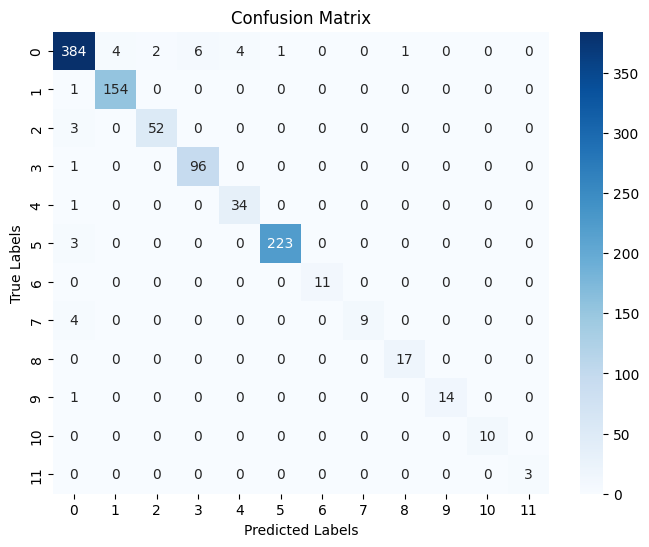

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix

# Assuming df is your pandas DataFrame
true_labels = oof_df["labels"].values
predicted_labels = oof_df["preds"].values

# Get the unique classes from both true and predicted labels
classes = np.unique(np.concatenate((true_labels, predicted_labels)))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

Text(0.5, 1.0, 'Confusion Matrix')

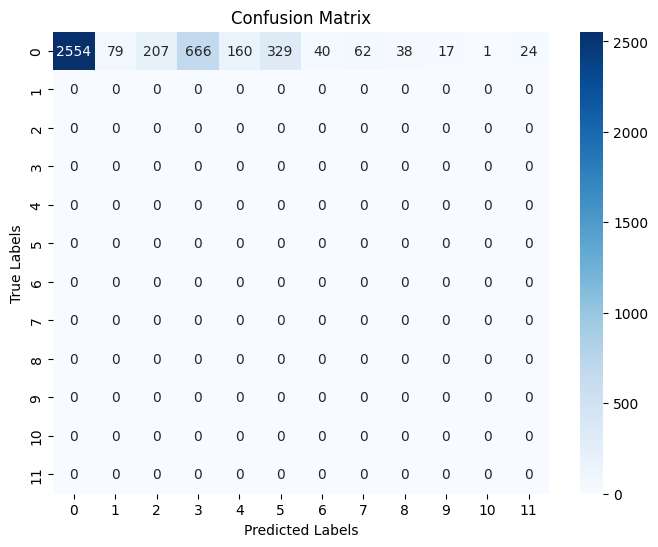

In [27]:
true_labels = test_folds["labels"].values
predicted_labels = test_folds["preds"].values

# Get the unique classes from both true and predicted labels
classes = np.unique(np.concatenate((true_labels, predicted_labels)))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [ ]:
!zip -r output.zip /kaggle/working/output

  adding: kaggle/working/output/ (stored 0%)
  adding: kaggle/working/output/config.pth (deflated 51%)
  adding: kaggle/working/output/test_fold.csv (deflated 97%)
  adding: kaggle/working/output/microsoft_deberta-v3-large_fold_2_best.pth